In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
recon = np.load('reconstructed_dm_pretrained_model.npy')
ground = np.load('ground_truth_pretrained_model.npy')

### Mean squared errors

In [14]:
mse_errors = []

for num, distance_map in enumerate(recon):
    mask = ground[num][0] != 0
    sum_result = np.sum(mask, axis=1)
    start_of_padding = sum_result[0]+1
    ground_truth_example = ground[num][0][:start_of_padding,:start_of_padding]
    recon_example = recon[num][0][:start_of_padding,:start_of_padding]
    np.fill_diagonal(recon_example, 0)
    
    upper_triangle = np.triu(recon_example)
    recon_example = upper_triangle + upper_triangle.T
    np.fill_diagonal(recon_example, 0)
    # Mean error of the reconstructed matrix
    mse_errors.append(np.sqrt(((ground_truth_example - recon_example)**2).mean()))
    
print(f'Mean error {np.mean(mse_errors):.2f}; std {np.std(mse_errors):.2f}')

Mean error 2.89; std 1.39


### Pick your example to plot

#### This will calculate where the padding starts

In [31]:
example = 0

mask = ground[example][0] != 0
sum_result = np.sum(mask, axis=1)
start_of_padding = sum_result[0]+1

##### Here we are extracting the examples defined above

In [32]:
ground_truth_example = ground[example][0][:start_of_padding,:start_of_padding]
recon_example = recon[example][0][:start_of_padding,:start_of_padding]

# Make the diagonal 0s in reconstructed matrix because we don't calculate loss on these in VAE
np.fill_diagonal(recon_example, 0)

In [33]:
upper_triangle = np.triu(recon_example)
recon_example = upper_triangle + upper_triangle.T
np.fill_diagonal(recon_example, 0)

In [34]:
# Mean error of the reconstructed matrix
np.sqrt(((ground_truth_example - recon_example)**2).mean())

3.0850112

#### Plot the ground truth, reconstructed map, and difference between the two

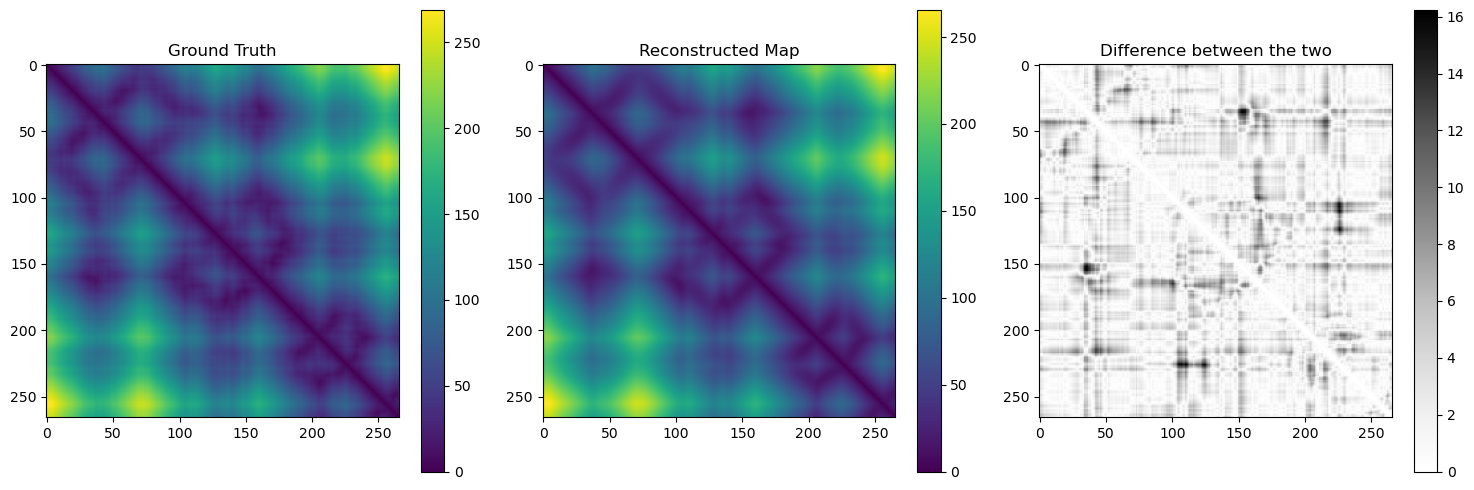

In [35]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot data1 in the first subplot
gt = axes[0].imshow(ground_truth_example, cmap='viridis')
axes[0].set_title('Ground Truth')
fig.colorbar(gt, ax=axes[0])

# Plot data2 in the second subplot
reconstructed = axes[1].imshow(recon_example, cmap='viridis')
axes[1].set_title('Reconstructed Map')
fig.colorbar(reconstructed, ax=axes[1])

# Plot data3 in the third subplot
difference = axes[2].imshow(abs(ground_truth_example - recon_example), cmap='Greys')
axes[2].set_title('Difference between the two')
fig.colorbar(difference, ax=axes[2])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()
# Show the plots
plt.show()

#### Make a contact map out of the distance maps

In [9]:
contact_distance = 25

recon_contact_map = np.where(recon_example < contact_distance, 1, 0)
ground_truth_contact_map = np.where(ground_truth_example < contact_distance, 1, 0)

# Remove the diagonal elements
np.fill_diagonal(recon_contact_map,0)
np.fill_diagonal(ground_truth_contact_map,0)

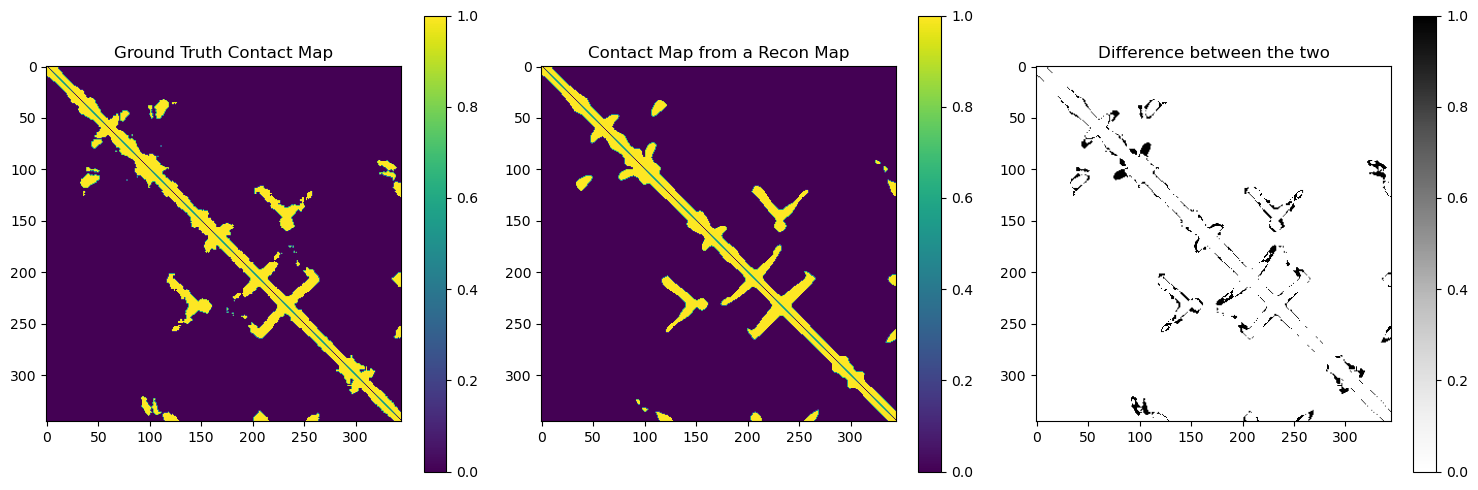

In [10]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot data1 in the first subplot
gt = axes[0].imshow(ground_truth_contact_map, cmap='viridis')
axes[0].set_title('Ground Truth Contact Map')
fig.colorbar(gt, ax=axes[0])

# Plot data2 in the second subplot
reconstructed = axes[1].imshow(recon_contact_map, cmap='viridis')
axes[1].set_title('Contact Map from a Recon Map')
fig.colorbar(reconstructed, ax=axes[1])

# Plot data3 in the third subplot
difference = axes[2].imshow(abs(ground_truth_contact_map - recon_contact_map), cmap='Greys')
axes[2].set_title('Difference between the two')
fig.colorbar(difference, ax=axes[2])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Show the plots
plt.show()

In [11]:
difference = np.abs(ground_truth_example - recon_example)

indices = np.where(difference==difference.max())

print(f'Largest deviation from ground truth {difference.max():.4f}A between bead {indices[0][0]} and {indices[1][0]}')

Largest deviation from ground truth 20.0683A between bead 60 and 309


## Reconstruction error of bond lengths

In [12]:
bond_length_errors = np.abs([ground_truth_example[i,i+1] - recon_example[i,i+1] for i in range(start_of_padding-1)])
mean_error = bond_length_errors.mean()
max_error = bond_length_errors.max()

print(f'Mean error of bond length reconstruction: {mean_error:.4f}A')
print(f'Max error of bond length reconstruction: {max_error:.4f}A')

Mean error of bond length reconstruction: 0.0526A
Max error of bond length reconstruction: 0.2225A


## Are there any beads that are clashing with other beads?

In [13]:
clash_distance = 6.27

clash_mask = np.where(recon_example < clash_distance, 1, 0)

# Remove the diagonal elements
np.fill_diagonal(clash_mask,0)

# Remove off-diagonal elements one position below the main diagonal
np.fill_diagonal(clash_mask[1:], 0) 

# Remove off-diagonal elements one position above the main diagonal
np.fill_diagonal(clash_mask[:,1:], 0)

print(f'Number of clashing beads: {clash_mask.sum()/2}')

Number of clashing beads: 0.0


#### Plot where the clash is

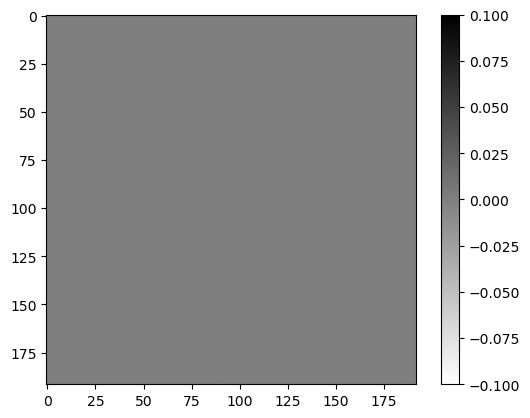

In [12]:
plt.imshow(clash_mask,cmap='binary')
plt.colorbar()

#### What is the distribution of error

In [14]:
start = 3
end = 5
stride = end-start

num_bins = int((ground_truth_example.max()-start)/stride)

mean_errors = []
max_errors = []

labels = []


for i in range(num_bins):
    ground_mask = np.where((start < ground_truth_example) & (ground_truth_example < end), 1, 0)
    ground_truth_distances = ground_truth_example * ground_mask
    recon_distances = recon_example * ground_mask
    absolute_difference = abs(ground_truth_distances-recon_distances)
    mean_absolute_difference = absolute_difference.sum()/np.count_nonzero(absolute_difference)
    max_errors.append(absolute_difference.max())
    mean_errors.append(mean_absolute_difference)
    labels.append(end)
    
    start += stride
    end += stride

Text(0, 0.5, 'Error in Angstrom')

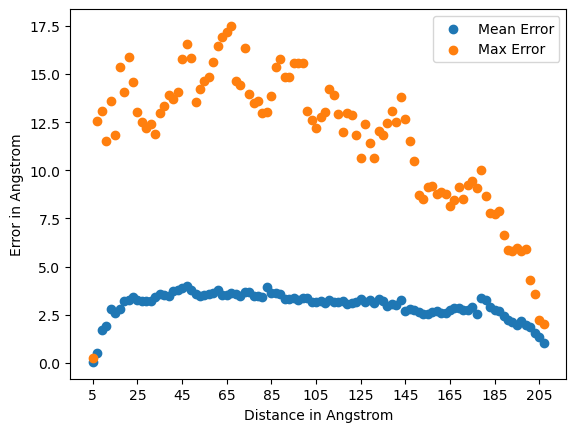

In [15]:
plt.scatter(range(len(mean_errors)),mean_errors, label='Mean Error')
plt.scatter(range(len(max_errors)),max_errors, label='Max Error')
plt.xticks(range(len(mean_errors))[::10], labels[::10])
plt.legend()

plt.xlabel('Distance in Angstrom')
plt.ylabel('Error in Angstrom')

Text(0, 0.5, 'Error in Angstrom')

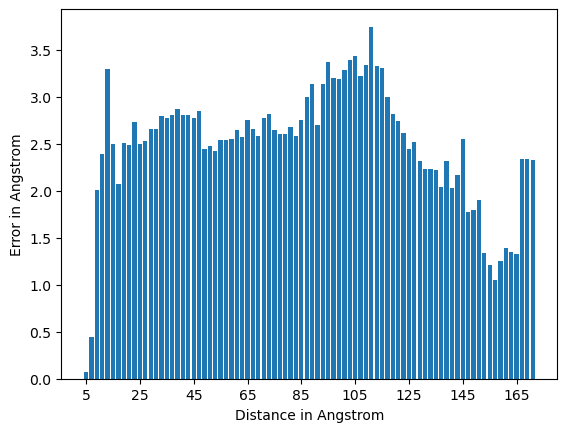

In [16]:
plt.bar(range(len(mean_errors)),mean_errors)
plt.xticks(range(len(mean_errors))[::10], labels[::10])

plt.xlabel('Distance in Angstrom')
plt.ylabel('Error in Angstrom')

In [17]:
import numpy as np

import numpy as np

def inverse_distance_weight(distances, max_distance, min_weight=0, max_weight=1):
    """
    Calculate weights based on inverse distances in a 2D space.

    Parameters:
    - distances (numpy array): Array of distances.
    - max_distance (float): Maximum distance.
    - min_weight (float, optional): Minimum weight (default is 0).
    - max_weight (float, optional): Maximum weight (default is 1).

    Returns:
    - weights (numpy array): Calculated weights.
    """
    inverse_distances = 1 / distances
    inverse_distances[np.isinf(inverse_distances)] = 0
    inverse_max_distance = np.max(inverse_distances)
    slope = (max_weight - min_weight) / inverse_max_distance
    weights = slope * inverse_distances + min_weight
    return weights

# Example usage
# Assuming distances is a 2D array where each row represents the distances from a point to all other points
# distances[i, j] represents the distance between point i and point j
distances = ground_truth_example

# Calculate the maximum distance
max_distance = np.max(distances)

# Calculate weights based on inverse distances
weights = inverse_distance_weight(distances, max_distance)

print(weights)

[[0.         0.99999887 0.5259881  ... 0.0291321  0.02834738 0.02810143]
 [0.99999887 0.         0.99999887 ... 0.02967802 0.02886746 0.02862922]
 [0.5259881  0.99999887 0.         ... 0.02970318 0.02889593 0.0286794 ]
 ...
 [0.0291321  0.02967802 0.02970318 ... 0.         0.999999   0.5811978 ]
 [0.02834738 0.02886746 0.02889593 ... 0.999999   0.         0.9999983 ]
 [0.02810143 0.02862922 0.0286794  ... 0.5811978  0.9999983  0.        ]]


/tmp/ipykernel_1652014/1819979066.py:18: RuntimeWarning: divide by zero encountered in divide
  inverse_distances = 1 / distances


In [65]:
weights = weights/(weights.sum()/2)

In [168]:
weights_reciprocal = 1/ground_truth_example
weights_reciprocal[np.isinf(weights_reciprocal)] = 0

weights_reciprocal = weights_reciprocal/(weights_reciprocal.sum())

/tmp/ipykernel_3607558/2260560543.py:1: RuntimeWarning: divide by zero encountered in divide
  weights_reciprocal = 1/ground_truth_example


In [169]:
weights_reciprocal_wrong = 1/ground_truth_example
weights_reciprocal_wrong[np.isinf(weights_reciprocal_wrong)] = 0

weights_reciprocal_squared = weights_reciprocal_wrong/(weights_reciprocal_wrong.sum()/2)

/tmp/ipykernel_3607558/2459386844.py:1: RuntimeWarning: divide by zero encountered in divide
  weights_reciprocal_wrong = 1/ground_truth_example


In [170]:
weights_reciprocal_squared = 1/ground_truth_example**2
weights_reciprocal_squared[np.isinf(weights_reciprocal_squared)] = 0

weights_reciprocal_squared = weights_reciprocal_squared/(weights_reciprocal_squared.sum())

/tmp/ipykernel_3607558/458540786.py:1: RuntimeWarning: divide by zero encountered in divide
  weights_reciprocal_squared = 1/ground_truth_example**2


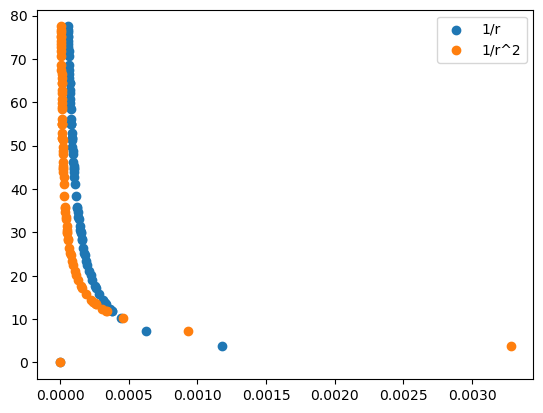

In [173]:
plt.scatter(weights_reciprocal[0], ground_truth_example[0], label='1/r')
plt.scatter(weights_reciprocal_squared[0], ground_truth_example[0], label='1/r^2')
plt.legend()
# plt.scatter(weights[0], ground_truth_example[0])

In [89]:
data = np.random.rand(100, 100)
target = np.random.rand(100, 100)

In [90]:
mse = np.mean((data-target)**2)

In [91]:
mse

0.16723325642657047

In [101]:
weights = np.ones((100,100))

In [102]:
squared_diffs = (data-target)**2
((squared_diffs*weights)/weights.sum()).sum()

0.16723325642657047

In [116]:
test = np.linspace(1,100,100)

In [146]:
max_distance = ground_truth_example.max()
min_distance = ground_truth_example.min()
weights = 1 - (ground_truth_example-min_distance)/(max_distance-min_distance)
np.fill_diagonal(weights,0)
weights = weights/weights.sum()

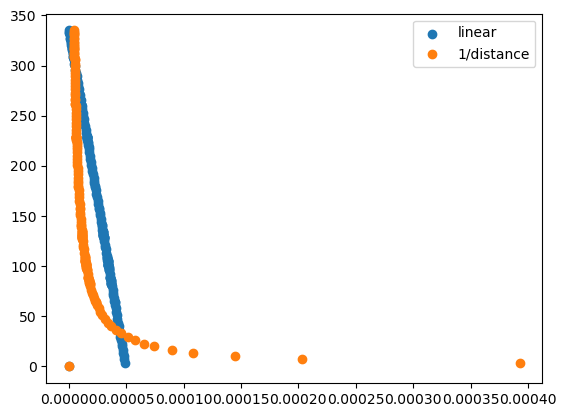

In [147]:
plt.scatter(weights[0],ground_truth_example[0], label='linear')
plt.scatter(weights_reciprocal[0], ground_truth_example[0], label='1/distance')
plt.legend()

In [174]:
weights.sum()

1.0

#### Analyze generated distances by sampling from N(0,I)

In [25]:
# sampled_distance_maps = np.load('VAE_resnet18_generated.npy')
sampled_distance_maps = np.load('/home/bnovak/projects/autoencoder_training/VAE_training/testing_cond_vae/generated_distance_maps.npy')

In [30]:
example = 6

sampled_example = sampled_distance_maps[example][0]

upper_triangle = np.triu(sampled_example)
sampled_example = upper_triangle + upper_triangle.T
np.fill_diagonal(sampled_example, 0)

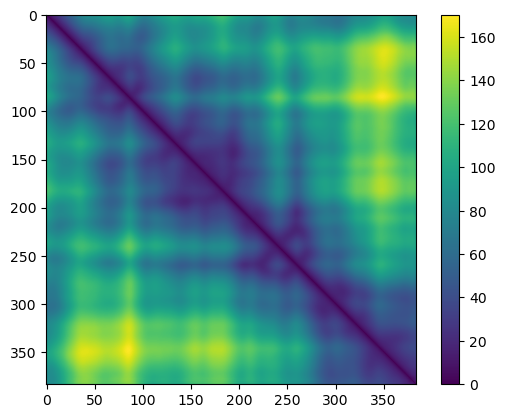

In [31]:
plt.imshow(sampled_example)
plt.colorbar()

In [32]:
end_to_end_distance_sampled = [distance[0,-1] for distance in sampled_distance_maps[:,0]]

(array([ 61., 143., 166., 180., 188., 131.,  70.,  40.,  15.,   6.]),
 array([ 28.36176872,  46.21796036,  64.07415009,  81.93034363,
         99.78652954, 117.64272308, 135.49891663, 153.35510254,
        171.21128845, 189.06748962, 206.92367554]),
 <BarContainer object of 10 artists>)

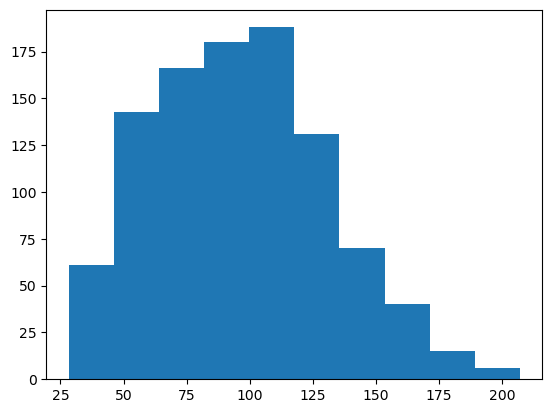

In [33]:
plt.hist(end_to_end_distance_sampled)

In [34]:
average_distance_map = np.mean(sampled_distance_maps, axis=0)[0]

upper_triangle = np.triu(average_distance_map)
average_distance_map = upper_triangle + upper_triangle.T
np.fill_diagonal(average_distance_map, 0)

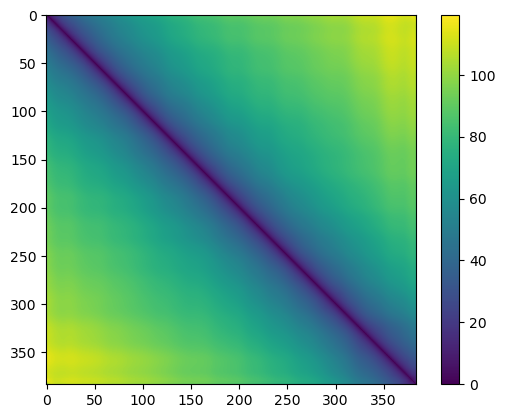

In [35]:
plt.imshow(average_distance_map)
plt.colorbar()

In [18]:
bond_lengths = []
mean_bond_lengths = []

for sampled_example in sampled_distance_maps:
    upper_triangle = np.triu(sampled_example[0])
    sampled_example = upper_triangle + upper_triangle.T
    np.fill_diagonal(sampled_example, 0)
    bonds = np.array([sampled_example[i,i+1] for i in range(383)])
    bond_lengths.append(bonds)
    mean_bond_lengths.append(bonds.mean())
    
    

In [19]:
clash = []

for sampled_example in sampled_distance_maps:
    upper_triangle = np.triu(sampled_example[0])
    sampled_example = upper_triangle + upper_triangle.T
    np.fill_diagonal(sampled_example, 0)
    clash_distance = 6.27

    clash_mask = np.where(sampled_example < clash_distance, 1, 0)

    # Remove the diagonal elements
    np.fill_diagonal(clash_mask,0)

    # Remove off-diagonal elements one position below the main diagonal
    np.fill_diagonal(clash_mask[1:], 0) 

    # Remove off-diagonal elements one position above the main diagonal
    np.fill_diagonal(clash_mask[:,1:], 0)
    
    clash.append(clash_mask.sum()/2)
    

In [23]:
sampled_distance_maps.shape

(1000, 1, 384, 384)

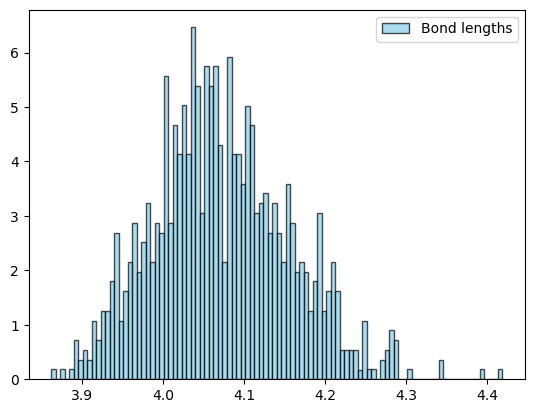

In [24]:
plt.hist(mean_bond_lengths, bins=100, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Bond lengths')
plt.legend()

In [116]:
import glob

files = glob.glob('/home/bnovak/projects/VAE_training/random_walk_pretraining/192/*gz')

In [117]:
ground_truth = np.array([np.loadtxt(i) for i in files])

In [25]:
average_truth = np.mean(ground_truth,axis=0)

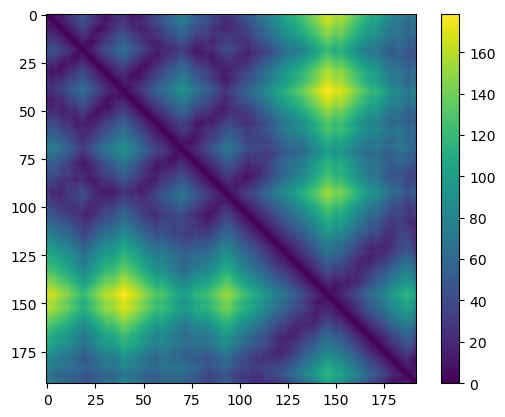

In [26]:
plt.imshow(ground_truth[70])
plt.colorbar()

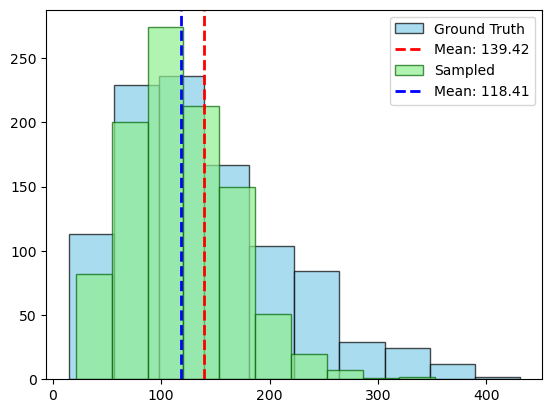

In [118]:
end_to_end_distance = [distance[0,-1] for distance in ground_truth]

plt.hist(end_to_end_distance, color='skyblue', edgecolor='black', alpha=0.7, label='Ground Truth')
plt.axvline(np.mean(end_to_end_distance), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(end_to_end_distance):.2f}')
plt.hist(end_to_end_distance_sampled, color='lightgreen', edgecolor='darkgreen', alpha=0.7, label='Sampled')
plt.axvline(np.mean(end_to_end_distance_sampled), color='blue', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(end_to_end_distance_sampled):.2f}')
plt.legend()

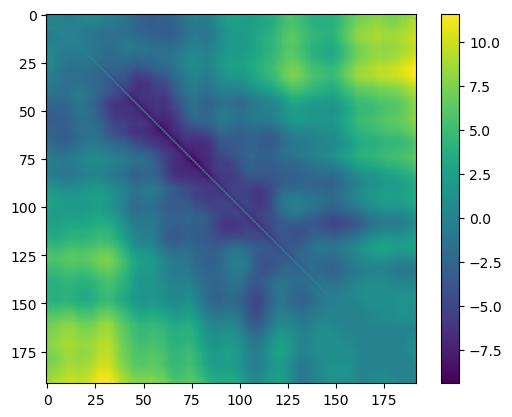

In [53]:
plt.imshow(average_truth-average_distance_map)
plt.colorbar()

In [68]:
from afrc import AnalyticalFRC

In [69]:
protein = AnalyticalFRC('G'*192)

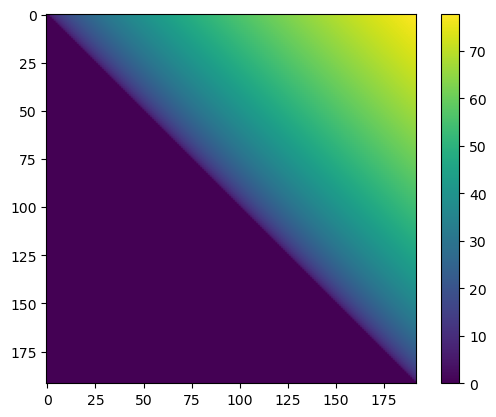

In [72]:
plt.imshow(protein.get_distance_map())
plt.colorbar()

### Normalizing Data

In [100]:
import glob 
from tqdm import tqdm
import numpy as np

training_data = glob.glob('/home/bnovak/projects/VAE_training/small_384_model/training_data/384/*')

data = []

for i in training_data[::100]:
    data.append(np.loadtxt(i))
    
data = np.array(data)
mean_data = np.mean(data, axis=0)
std_data = np.std(data, axis=0)
max_data = np.max(data, axis=0)
padded_mask = (data != 0)
min_data = np.min(data, axis=0, where=padded_mask, initial=np.inf)

# min_data = np.min

# min_array = np.load('../data/minimum_expected_distances.npy')
# max_array = np.load('../data/max_expected_distances_384.npy')

In [672]:
def min_max_scale(x, min_val, max_val):
    denominator = (max_val - min_val)
    denominator[denominator == 0] = 1
    normalized_data = (x - min_val) / denominator
    return normalized_data


def reciprocal(x):
    y = 1/x
    y[np.isinf(y)] = 0
    return y

# data = data[10]

data_recip = reciprocal(data)
min_recip = reciprocal(min_array)
max_recip = reciprocal(max_array)

min_recip_values = np.minimum(min_recip,max_recip)
max_recip_values = np.maximum(min_recip,max_recip)

normalized_data_recip = min_max_scale(data_recip, min_recip_values, max_recip_values)

def reciprocal_log(x):
    y = 1/(np.log(x))
    y[np.isinf(y)] = 0
    return y

data_recip_log = reciprocal_log(data)
min_recip_log = reciprocal_log(min_array.round(3))
max_recip_log = reciprocal_log(max_array.round(3))

min_recip_values_log = np.minimum(min_recip_log,max_recip_log)
max_recip_values_log = np.maximum(min_recip_log,max_recip_log)

normalized_data_recip_log = min_max_scale(data_recip_log, min_recip_values_log, max_recip_values_log)

def log(x):
    y = np.log(x)
    y[np.isinf(y)] = 0
    return y

data_log = log(data)
min_log = log(min_array)
max_log = log(max_array)

min_values_log = np.minimum(min_log,max_log)
max_values_log = np.maximum(min_log,max_log)

normalized_data_log = min_max_scale(data_log, min_values_log, max_values_log)

/tmp/ipykernel_529069/51155493.py:9: RuntimeWarning: divide by zero encountered in divide
  y = 1/x
/tmp/ipykernel_529069/51155493.py:25: RuntimeWarning: divide by zero encountered in log
  y = 1/(np.log(x))
/tmp/ipykernel_529069/51155493.py:39: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)


In [407]:
np.log(min_array/data[10])/np.log(max_array/min_array)

/tmp/ipykernel_529069/3857347847.py:1: RuntimeWarning: invalid value encountered in divide
  np.log(min_array/data[10])/np.log(max_array/min_array)


array([[        nan, -0.46779757, -0.65730228, ..., -0.71029373,
        -0.70663041, -0.70989777],
       [-0.46779757,         nan, -0.47019966, ..., -0.70751572,
        -0.70578825, -0.70984584],
       [-0.65730228, -0.47019966,         nan, ..., -0.70309345,
        -0.7037475 , -0.70571406],
       ...,
       [-0.71029373, -0.70751572, -0.70309345, ...,         nan,
        -0.4680871 , -0.38141387],
       [-0.70663041, -0.70578825, -0.7037475 , ..., -0.4680871 ,
                nan, -0.42148954],
       [-0.70989777, -0.70984584, -0.70571406, ..., -0.38141387,
        -0.42148954,         nan]])

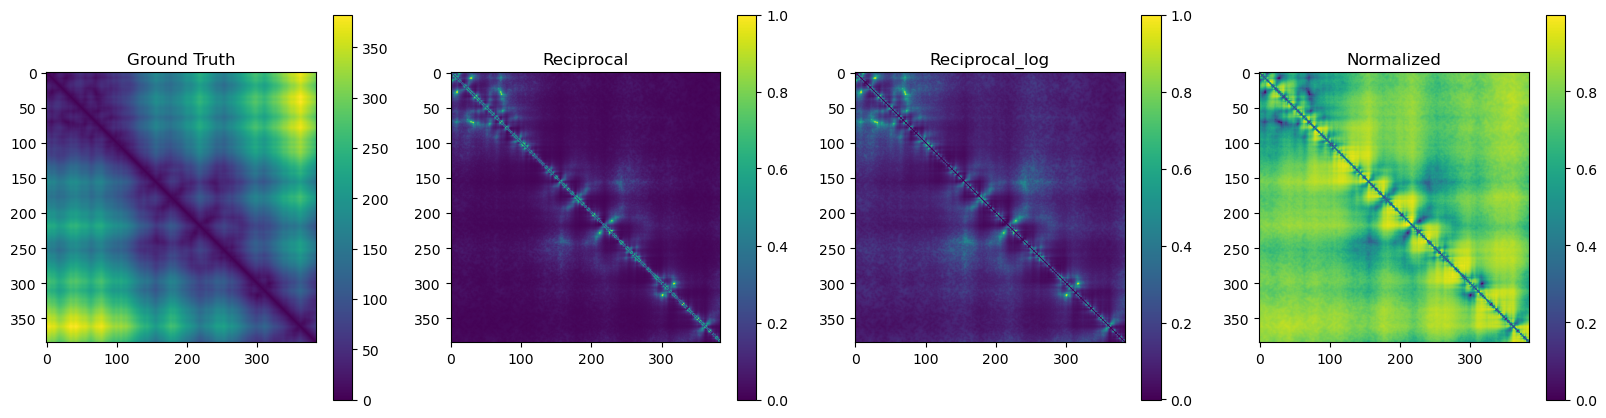

In [673]:
import matplotlib.pyplot as plt

example = 0

# Create a figure with two subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot data1 in the first subplot
gt = axes[0].imshow(data[example], cmap='viridis')
axes[0].set_title('Ground Truth')
fig.colorbar(gt, ax=axes[0])

# Plot data1 in the first subplot
gt = axes[1].imshow(normalized_data_recip[example], cmap='viridis')
axes[1].set_title('Reciprocal')
plt.colorbar(gt, ax=axes[1])

# Plot data1 in the first subplot
gt = axes[2].imshow(normalized_data_recip_log[example], cmap='viridis')
axes[2].set_title('Reciprocal_log')
plt.colorbar(gt, ax=axes[2])

# Plot data1 in the first subplot
gt = axes[3].imshow(normalized_data_log[example], cmap='viridis')
axes[3].set_title('Normalized')
plt.colorbar(gt, ax=axes[3])

In [3]:
data = np.loadtxt(training_data[30])

/tmp/ipykernel_4616/2980104089.py:4: RuntimeWarning: divide by zero encountered in log
  y = 1/(np.log(x))


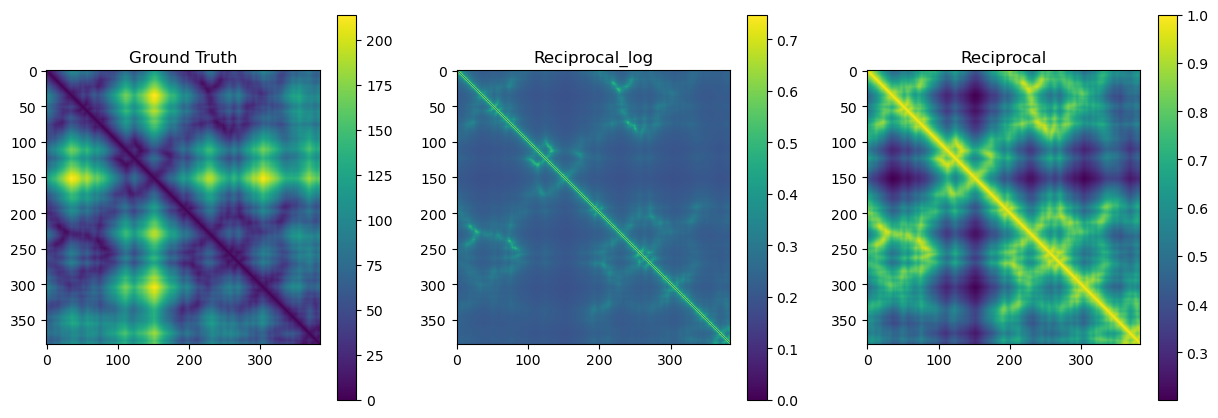

In [46]:
import matplotlib.pyplot as plt

def reciprocal_log(x):
    y = 1/(np.log(x))
    y[y == 0] = 0
    return y

def log(x):
    y = np.log(x)
    y[np.isinf(y)] = 0
    return y

def reciprocal(x):
    y = 1/x
    y[np.isinf(y)] = 0
    return y

def negative_exp(x):
    y = np.exp(-x/134)
    # y[np.isinf(y)] = 0
    return y

example = 0

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot data1 in the first subplot
gt = axes[0].imshow(data, cmap='viridis')
axes[0].set_title('Ground Truth')
fig.colorbar(gt, ax=axes[0])

# Plot data1 in the first subplot
gt = axes[1].imshow(reciprocal_log(data), cmap='viridis')
axes[1].set_title('Reciprocal_log')
plt.colorbar(gt, ax=axes[1])


# Plot data1 in the first subplot
gt = axes[2].imshow(negative_exp(data), cmap='viridis')
axes[2].set_title('Reciprocal')
plt.colorbar(gt, ax=axes[2])



In [1]:
reciprocal(data)[0]

NameError: name 'reciprocal' is not defined

In [154]:
flattened_distances = max_array.flatten()
sorted_distances = np.sort(flattened_distances)

num_distances = len(sorted_distances)
index_90th_percentile = int(0.9 * num_distances)

distance_90th_percentile = sorted_distances[index_90th_percentile]

In [155]:
distance_90th_percentile

704.42993

(array([25., 54., 94., 69., 76., 31., 20.,  8.,  4.,  3.]),
 array([0.30748216, 0.37673395, 0.44598573, 0.51523751, 0.5844893 ,
        0.65374108, 0.72299287, 0.79224465, 0.86149643, 0.93074822,
        1.        ]),
 <BarContainer object of 10 artists>)

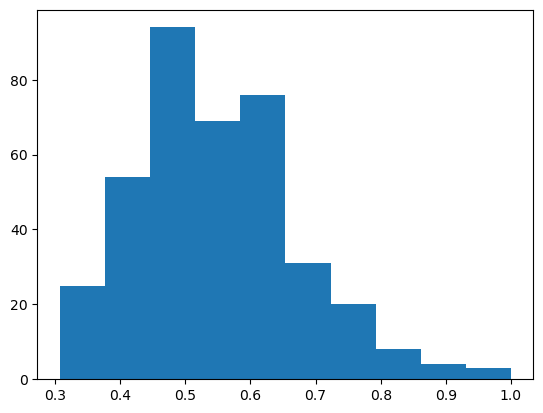

In [43]:
plt.hist(negative_exp(data)[0])

In [7]:
data = np.loadtxt(training_data[100])

In [259]:
class test():
    def __init__(self):
        self.target_shape = (384,)
        
        self.min_array = np.full(self.target_shape,np.inf)
        self.max_array = np.full(self.target_shape,-np.inf)
    
    def reciprocal_log(self, data):
        data_recip = 1 / (np.log(data))
        data_recip[data_recip == -0] = 0
        data_recip[np.isinf(data_recip)] = 0
        return data_recip
    
    def reciprocal(self, data):
        data_recip = 1 / data
        data_recip[data_recip == -0] = 0
        data_recip[np.isinf(data_recip)] = 0
        return data_recip
    
    def negative_exp(self,x):
        y = np.exp(-x/300)
        np.fill_diagonal(y, 0)
        # y[np.isinf(y)] = 0
        return y

    def calculate_min_max_reference(self, data):
        self.padded_mask = (data != 0)
        min_data = np.min(data, where=self.padded_mask, axis=0, initial=np.inf)
        max_data = np.max(data, axis=0)
        self.max_array = np.maximum(self.max_array, np.where(self.padded_mask, max_data, self.max_array))
        self.min_array = np.minimum(self.min_array, np.where(self.padded_mask, min_data, self.min_array))
        
    def min_max_scale(self, data):
        denominator = self.max_array - self.min_array
        denominator[denominator == 0] = 1
        normalized_data = (data - self.min_array) / denominator
        return normalized_data

    def reciprocal_log_normalization(self, original_array):
        # reciprocal_log_data = self.reciprocal_log(original_array.round(3))
        reciprocal_log_data = self.reciprocal(original_array.round(3))
        # reciprocal_log_data = self.negative_exp(original_array.round(3))
        self.calculate_min_max_reference(reciprocal_log_data)
        normalized_data = self.min_max_scale(reciprocal_log_data)
        normalized_data[np.isnan(normalized_data)] = 0
        return normalized_data
    

In [54]:

def reciprocal(data):
    data_recip = 1 / data
    data_recip[data_recip == -0] = 0
    data_recip[np.isinf(data_recip)] = 0
    return data_recip



def log(data):
    data_log = np.log(data)
    np.fill_diagonal(data_log,0)
    return data_log

In [45]:
data[0].min()

0.0

In [63]:
data_log = log(data[756]/3.81)

/tmp/ipykernel_685542/219056837.py:10: RuntimeWarning: divide by zero encountered in log
  data_log = np.log(data)


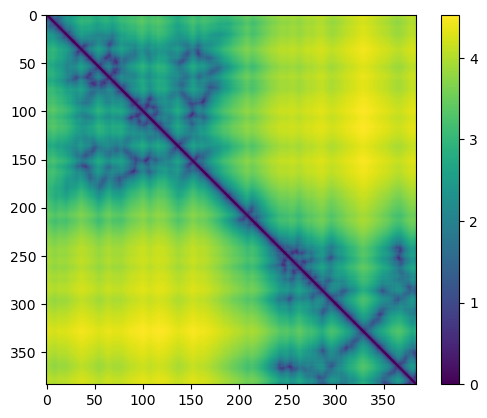

In [64]:
plt.imshow(data_log)
plt.colorbar()

In [260]:
testing_code = test()

In [261]:
norm = [testing_code.reciprocal_log_normalization(i) for i in data]

/tmp/ipykernel_42760/641372306.py:15: RuntimeWarning: divide by zero encountered in divide
  data_recip = 1 / data
/tmp/ipykernel_42760/641372306.py:36: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - self.min_array) / denominator


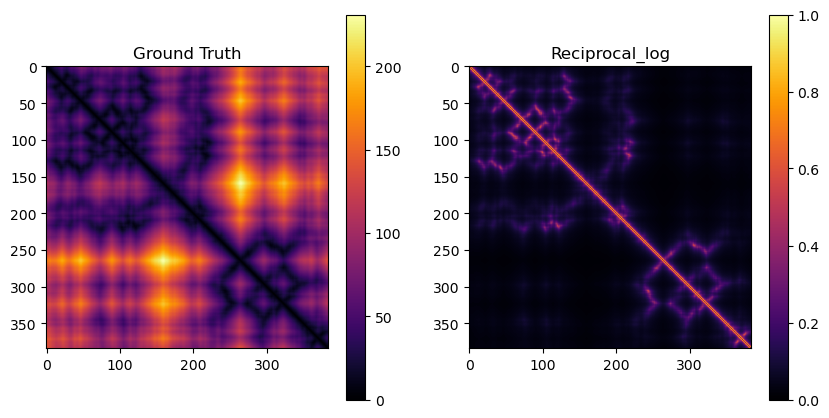

In [264]:
import matplotlib.pyplot as plt

example = 100

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot data1 in the first subplot
gt = axes[0].imshow(data[example], cmap='inferno')
axes[0].set_title('Ground Truth')
fig.colorbar(gt, ax=axes[0])

# Plot data1 in the first subplot
gt = axes[1].imshow(norm[example], cmap='inferno')
axes[1].set_title('Reciprocal_log')
plt.colorbar(gt, ax=axes[1])


In [253]:
testing = norm[example].round(3)

padded_mask = (testing != 0)
min_data = np.min(testing, where=padded_mask, axis=0, initial=np.inf)
max_data = testing.max(axis=0)

denominator = max_data - min_data
denominator[denominator == 0] = 1

testing_norm = abs((testing - min_data)/ denominator)

In [254]:
testing_norm

array([[0.01779359, 0.0177305 , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.01779359, 0.0177305 , 0.01785714, ..., 0.98785425, 0.98387097,
        0.9844358 ],
       [0.        , 0.0177305 , 0.01785714, ..., 0.95951417, 0.95564516,
        0.95719844],
       ...,
       [0.85409253, 0.84397163, 0.83214286, ..., 0.02024291, 0.02419355,
        0.        ],
       [0.85409253, 0.84397163, 0.83214286, ..., 0.02024291, 0.02419355,
        0.01945525],
       [0.87544484, 0.86524823, 0.85357143, ..., 0.        , 0.02419355,
        0.01945525]])

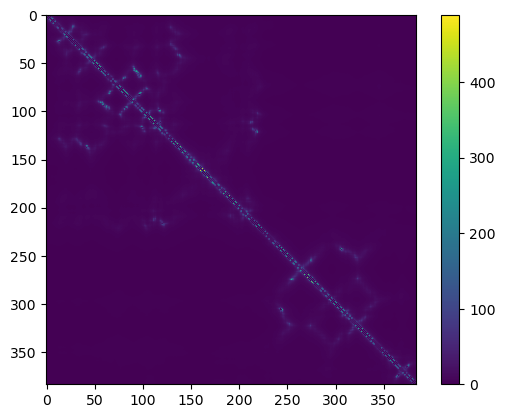

In [258]:
plt.imshow(scaled)
plt.colorbar()

In [256]:
scaled = 1/testing_norm
scaled[np.isinf(scaled)] = 1
np.fill_diagonal(scaled,0)


/tmp/ipykernel_42760/307758868.py:1: RuntimeWarning: divide by zero encountered in divide
  scaled = 1/testing_norm


In [257]:
scaled[0]

array([ 0.        , 56.4       ,  1.        , 94.33333333, 31.44444444,
       20.28571429, 14.84210526, 12.54545455,  9.48275862,  8.20588235,
        6.75609756,  5.9787234 ,  5.50980392,  5.2037037 ,  5.        ,
        4.96551724,  4.45454545,  4.33333333,  4.04054054,  3.88461538,
        3.73493976,  3.73493976,  3.92405063,  4.32857143,  4.53846154,
        4.64516129,  4.62295082,  4.79310345,  4.58333333,  4.37096774,
        3.97058824,  3.68055556,  3.41025641,  3.25609756,  3.12643678,
        3.16091954,  3.29411765,  3.36470588,  3.37931034,  3.30769231,
        3.15625   ,  3.13265306,  3.04950495,  2.96261682,  2.88392857,
        2.8362069 ,  2.7398374 ,  2.63565891,  2.5530303 ,  2.54198473,
        2.56692913,  2.584     ,  2.49612403,  2.48837209,  2.51587302,
        2.63333333,  2.66666667,  2.68695652,  2.62068966,  2.69369369,
        2.65765766,  2.65137615,  2.66037736,  2.5       ,  2.36206897,
        2.23577236,  2.12598425,  2.08661417,  2.088     ,  2.08

In [178]:
test = np.abs((data[example] - 100))
np.fill_diagonal(test,0)

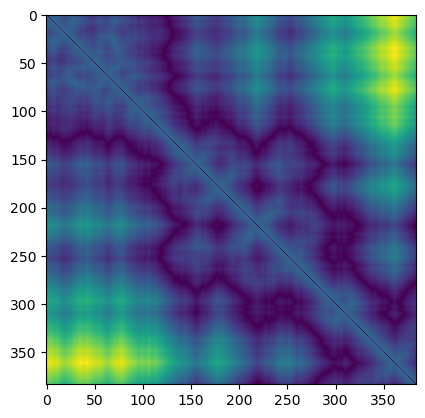

In [179]:
plt.imshow(test)

In [84]:
norm = np.array(norm)

[norm[:,i,i+1] for i in range(383)]

AttributeError: 'list' object has no attribute 'min'

In [7]:
generated = np.load('generated_distance_maps.npy')

In [15]:
generate_example = test[75][0]

upper_triangle = np.triu(generate_example)
generate_example = upper_triangle + upper_triangle.T
np.fill_diagonal(generate_example, 0)

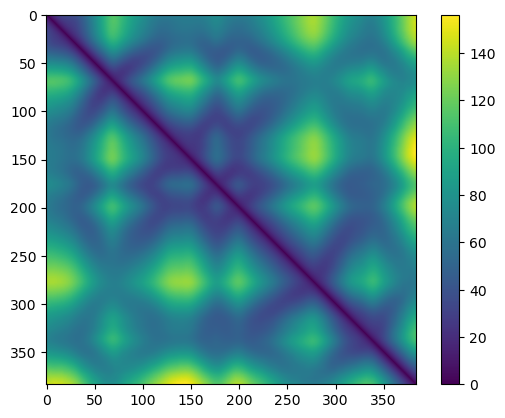

In [16]:
plt.imshow(generate_example)
plt.colorbar()

In [3]:
latents_VAE = np.load('latent1_latent2_VAE.npy')
latents_AE = np.load('latent1_latent2_AE.npy')

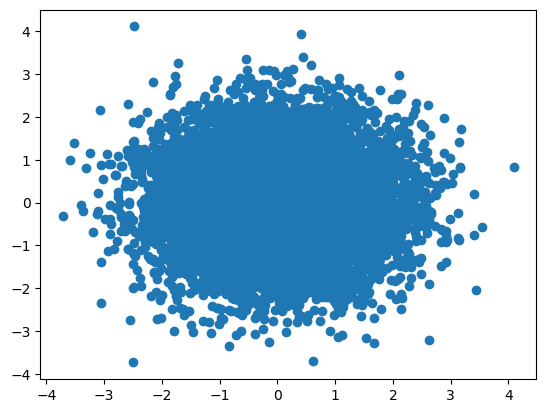

In [4]:
plt.scatter(latents_VAE[:,0], latents_VAE[:,1], label='VAE')

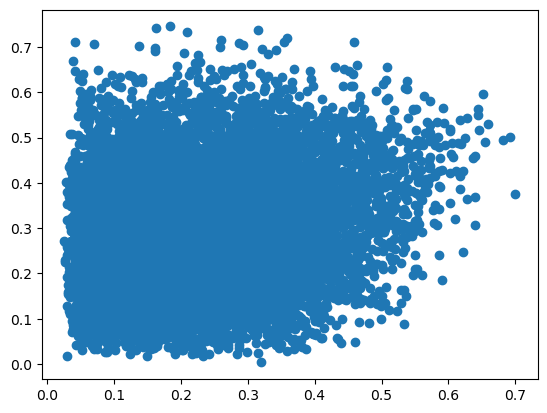

In [5]:
plt.scatter(latents_AE[:,0], latents_AE[:,1], label='AE')

In [2]:
import metapredict as meta
# from sparrow import Protein
from finches.frontend.mpipi_frontend import Mpipi_frontend
from finches.frontend.calvados_frontend import CALVADOS_frontend

In [31]:
mf = Mpipi_frontend()
cf = CALVADOS_frontend()

protein = 'AKEDCNFW'

In [32]:
test = mf.intermolecular_idr_matrix(protein,protein, window_size=1)

In [21]:
# sampled_distance_maps = np.load('VAE_resnet18_generated.npy')
sampled_distance_maps_Q = np.load('/home/bnovak/projects/autoencoder_training/VAE_training/testing_cond_vae/Q.npy')
sampled_distance_maps_E = np.load('/home/bnovak/projects/autoencoder_training/VAE_training/testing_cond_vae/E.npy')

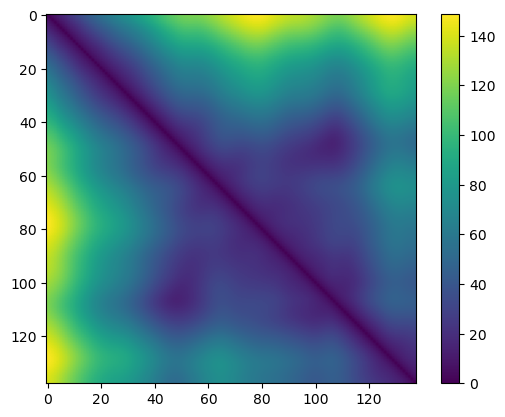

In [22]:
upper_triangle = np.triu(sampled_distance_maps_Q[0][0])
sampled_distance_maps_Q = upper_triangle + upper_triangle.T
np.fill_diagonal(sampled_distance_maps_Q, 0)

plt.imshow(sampled_distance_maps_Q)
plt.colorbar()

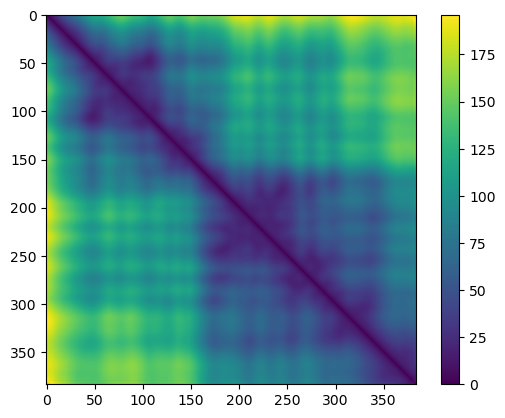

In [23]:
upper_triangle = np.triu(sampled_distance_maps_E[0][0])
sampled_distance_maps_E = upper_triangle + upper_triangle.T
np.fill_diagonal(sampled_distance_maps_E, 0)

plt.imshow(sampled_distance_maps_E)

plt.colorbar()